In [1]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image
from utils import get_data, save_list, load_list
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils import save_list, load_list
from train import adv_classifier, train, train_bound, test, adjust_lr, weights_init

import torch.nn as nn
import torch.nn.functional as F
import torch
import pickle
import time
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import torchvision
from torchvision.transforms import transforms

from tqdm.notebook import tqdm
import time
from models import modelA
from train_vgg19 import vgg19
from utils import get_data, load_list, save_list
from utils import normalize as Normalize
import warnings

from sklearn.preprocessing import scale
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_curve, auc
import scipy.io as sio
from sklearn.preprocessing import scale
from advertorch.attacks import PGDAttack, GradientSignAttack, LinfBasicIterativeAttack, \
                                    CarliniWagnerL2Attack, DDNL2Attack, SinglePixelAttack, JacobianSaliencyMapAttack
from utils import CW

from sklearn.linear_model import LogisticRegressionCV


os.environ["CUDA_VISIBLE_DEVICES"]="7"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def Normalize(data):
    data[:,0,:,:] -= 0.5
    data[:,0,:,:] /= 1
    
    data[:,1,:,:] -= 0.5
    data[:,1,:,:] /= 1
    
    data[:,2,:,:] -= 0.5
    data[:,2,:,:] /= 1
    
    return data

def Denormalize(data):
    data[:,0,:,:] *= 1
    data[:,0,:,:] += 0.5
    
    data[:,1,:,:] *= 1
    data[:,1,:,:] += 0.5
    
    data[:,2,:,:] *= 1
    data[:,2,:,:] += 0.5
    
    return data

In [3]:
def flip(x, nb_diff):
    original_shape = x.shape
    x = np.copy(np.reshape(x, (-1,)))
    candidate_inds = np.where(x < 0.99)[0]
    assert candidate_inds.shape[0] >= nb_diff
    inds = np.random.choice(candidate_inds, nb_diff)
    x[inds] = 1.

    return np.reshape(x, original_shape)

In [4]:
def classifier_adv(data):
        return F.log_softmax(model(data))

In [5]:
def get_mc_predictions(model, X, nb_iter=50, batch_size=256):
    model.train()
    if dataset == 'mnist':
        output_dim = list(model.children())[-1].out_features
    else:
        output_dim = list(model.children())[-1][-1].out_features
    get_output = lambda data : F.softmax(model(data))
#     get_output = lambda data : model(data)
    X = torch.Tensor(X).to(device)
    
    def predict():
        n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
        output = np.zeros(shape=(len(X), output_dim))
        for i in range(n_batches):
            output[i * batch_size:(i + 1) * batch_size] = get_output(X[i * batch_size:(i + 1) * batch_size]).detach().cpu().numpy()
        return output

    preds_mc = []
    for i in tqdm(range(nb_iter)):
        preds_mc.append(predict())

    return np.asarray(preds_mc)

In [6]:
def get_deep_representations(model, X, batch_size=256):
    model.eval()
    X = torch.Tensor(X).to(device)
    # mnist modelA last hidden layer 
#     output_dim = model.layers[-4].output.shape[-1].value
    last_hidden_idx = -3
    if dataset == 'mnist':
        output_dim = list(model.children())[last_hidden_idx].out_features
    else:
        output_dim = list(model.children())[-1][last_hidden_idx].out_features

    last_hidden_output = None

    def last_hidden_hook(module, input_, output):
        nonlocal last_hidden_output
        last_hidden_output = output
    
    if dataset == 'mnist':
        list(model.children())[last_hidden_idx].register_forward_hook(last_hidden_hook)
    else:
        list(model.children())[-1][last_hidden_idx+1].register_forward_hook(last_hidden_hook)

    n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
    output = np.zeros(shape=(len(X), output_dim))
    for i in tqdm(range(n_batches)):
#         output[i * batch_size:(i + 1) * batch_size] = get_encoding([X[i * batch_size:(i + 1) * batch_size], 0])[0]
        model(X[i * batch_size:(i + 1) * batch_size])
        output[i * batch_size:(i + 1) * batch_size] = last_hidden_output.detach().cpu().numpy()
    return output

In [7]:
def score_point(tup):
    x, kde = tup
    return kde.score_samples(np.reshape(x, (1, -1)))[0]

def score_samples(kdes, samples, preds, n_jobs=None):
    if n_jobs is not None:
        p = mp.Pool(n_jobs)
    else:
        p = mp.Pool()
    
    results = p.map(score_point, [(x, kdes[i]) for x, i in zip(samples, preds)])
    p.close()
    p.join()

    return results

def normalize(normal, adv):
    n_samples = len(normal)
    total = scale(np.concatenate((normal, adv)))

    return total[:n_samples], total[n_samples:]

def train_lr(densities_pos, densities_neg, uncerts_pos, uncerts_neg):
    values_neg = np.concatenate(
        (densities_neg.reshape((1, -1)),
         uncerts_neg.reshape((1, -1))),
        axis=0).transpose([1, 0])
    values_pos = np.concatenate(
        (densities_pos.reshape((1, -1)),
         uncerts_pos.reshape((1, -1))),
        axis=0).transpose([1, 0])

    values = np.concatenate((values_neg, values_pos))
    labels = np.concatenate(
        (np.zeros_like(densities_neg), np.ones_like(densities_pos)))

    lr = LogisticRegressionCV(n_jobs=-1).fit(values, labels)

    return values, labels, lr



def compute_roc(probs_neg, probs_pos, labels, plot=True):
    """
    TODO
    :param probs_neg:
    :param probs_pos:
    :param plot:
    :return:
    """
    probs = np.concatenate((probs_neg, probs_pos))
    labels = np.concatenate((np.zeros_like(probs_neg), np.ones_like(probs_pos)))
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_score = auc(fpr, tpr)
    if plot:
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='blue',
                 label='ROC (AUC = %0.4f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
        plt.legend(loc='lower right')
        plt.title("ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return fpr, tpr, auc_score

In [80]:
dataset = 'cifar'
attack='pgd'

# X_train_list = '../gen/adv_data/v2/mnist/org/mnist_org_data/mnist_org_train_24000.pkl'

# X_test_list = '../gen/adv_data/v2/mnist/org/mnist_org_data/mnist_org_test_6000.pkl'

# X_train_adv_list = [
#     '../gen/adv_data/v2/mnist/fgsm/mnist_fgsm_attacked_eps0.30_tpr92/mnist_fgsm_train_8000.pkl',
#     '../gen/adv_data/v2/mnist/pgd/mnist_pgd_attacked_eps0.30_tpr100/mnist_pgd_train_8000.pkl',
#     '../gen/adv_data/v2/mnist/cw/mnist_cw_attacked_eps0.30_tpr100/mnist_cw_train_8000.pkl',
# ]

# X_test_adv_list = [
# #     '../gen/adv_data/v2/mnist/fgsm/mnist_fgsm_attacked_eps0.30_tpr92/mnist_fgsm_test_2000.pkl',
# #     '../gen/adv_data/v2/mnist/pgd/mnist_pgd_attacked_eps0.30_tpr100/mnist_pgd_test_2000.pkl',
#     '../gen/adv_data/v2/mnist/cw/mnist_cw_attacked_eps0.30_tpr100/mnist_cw_test_2000.pkl',
# ]

X_train_list = '../gen/adv_data/v2/cifar10/org/cifar10_org_data/cifar10_org_train_24000.pkl'

X_test_list = '../gen/adv_data/v2/cifar10/org/cifar10_org_data/cifar10_org_test_6000.pkl'

X_train_adv_list = [
    '../gen/adv_data/v2/cifar10/fgsm/cifar10_fgsm_attacked_eps0.01_tpr54/cifar10_fgsm_train_8000.pkl',
    '../gen/adv_data/v2/cifar10/pgd/cifar10_pgd_attacked_eps0.01_tpr64/cifar10_pgd_train_8000.pkl',
    '../gen/adv_data/v2/cifar10/cw/cifar10_cw_attacked_eps0.01_tpr62/cifar10_cw_train_8000.pkl',
]

X_test_adv_list = [
#     '../gen/adv_data/v2/cifar10/fgsm/cifar10_fgsm_attacked_eps0.01_tpr54/cifar10_fgsm_test_2000.pkl',
    '../gen/adv_data/v2/cifar10/pgd/cifar10_pgd_attacked_eps0.01_tpr64/cifar10_pgd_test_2000.pkl',
#     '../gen/adv_data/v2/cifar10/cw/cifar10_cw_attacked_eps0.01_tpr62/cifar10_cw_test_2000.pkl',
]



print('Loading %s data set' % dataset)
if dataset == 'mnist':
    X_train, Y_train = load_list(X_train_list)[0].reshape(-1, 1, 28, 28), load_list(X_train_list)[1]
    X_test, Y_test = load_list(X_test_list)[0].reshape(-1, 1, 28, 28), load_list(X_test_list)[1]
elif dataset == 'cifar':
    X_train, Y_train = load_list(X_train_list)[0].reshape(-1, 3, 32, 32), load_list(X_train_list)[1]
    X_test, Y_test = load_list(X_test_list)[0].reshape(-1, 3, 32, 32), load_list(X_test_list)[1]
    X_train = Normalize(X_train)
    X_test = Normalize(X_test)
    
X_train_adv = None
X_test_adv = None
Y_train_adv = None
Y_test_adv = None
for i in range(len(X_train_adv_list)):
    if i == 0:
        if dataset == 'mnist':
            X_train_adv = load_list(X_train_adv_list[i])[0].reshape(-1, 1, 28, 28)
            X_test_adv = load_list(X_test_adv_list[i])[0].reshape(-1, 1, 28, 28)
        elif dataset == 'cifar':
            X_train_adv = load_list(X_train_adv_list[i])[0].reshape(-1, 3, 32, 32)
            X_train_adv = Normalize(X_train_adv)
            X_test_adv = load_list(X_test_adv_list[i])[0].reshape(-1, 3, 32, 32)
            X_test_adv = Normalize(X_test_adv)
        Y_train_adv = load_list(X_train_adv_list[i])[1]
        Y_test_adv = load_list(X_test_adv_list[i])[1]
    else:
        if dataset == 'mnist':
            train_data = load_list(X_train_adv_list[i])[0].reshape(-1, 1, 28, 28)
        elif dataset == 'cifar':
            train_data = load_list(X_train_adv_list[i])[0].reshape(-1, 3, 32, 32)
            train_data = Normalize(train_data)
        train_label = load_list(X_train_adv_list[i])[1]
        X_train_adv = np.concatenate((X_train_adv, train_data))
        Y_train_adv = np.concatenate((Y_train_adv, train_label))


print('Loading %s data set finished' % dataset)
    
batch_size = 100
class_num = 10

# Gaussian kernel bandwidth for kernel density estimation
BANDWIDTHS = {'mnist': 1.20, 'cifar': 0.26}

Loading cifar data set
Loading cifar data set finished


In [81]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((24000, 3, 32, 32), (6000, 3, 32, 32), (24000,), (6000,))

In [82]:
X_train_adv.shape, X_test_adv.shape, Y_train_adv.shape, Y_test_adv.shape

((24000, 3, 32, 32), (2000, 3, 32, 32), (24000,), (2000,))

In [83]:
# mnist
if dataset == 'mnist':
    model = modelA()
    checkpoint = torch.load('../gen/models/mnist/modelA/modelA.pkl')
    model.load_state_dict(checkpoint)
    model.eval()
    model.to(device)
elif dataset == 'cifar':
    model = vgg19()
#     model.features = torch.nn.DataParallel(model.features)
    model.to(device)
    checkpoint = torch.load('../gen/models/cifar10/vgg19/scale_0.5/best.pt')
    model.load_state_dict(checkpoint)
    model.eval()
else:
    #Imagenet model loading
    pass
    
print('%s Model loading complete!'%dataset)

cifar Model loading complete!


In [84]:
for s_type, dset in zip(['normal train', 'normal test'], [[X_train, Y_train], [X_test, Y_test]]):
    model.eval()
    
    if dataset == 'mnist':
        dset = TensorDataset(torch.Tensor(dset[0].reshape(-1, 1, 28, 28)), torch.Tensor(dset[1]))
    elif dataset == 'cifar':
        dset = TensorDataset(torch.Tensor(dset[0].reshape(-1, 3, 32, 32)), torch.Tensor(dset[1]))
        
    dset_loader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=10)
        
    correct = 0
    for data, target in dset_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, 1)
        
        correct += (pred.detach().cpu().numpy() == target.cpu().numpy()).sum()
        
    acc = correct / len(dset)
    
    print("Model accuracy on the %s test set: %0.2f%%" %
              (s_type, 100 * acc))

Model accuracy on the normal train test set: 100.00%
Model accuracy on the normal test test set: 100.00%


# Bayesian uncertainty

In [85]:
print('Getting Monte Carlo dropout variance predictions...')
uncerts_normal_train = get_mc_predictions(model, X_train, batch_size=batch_size).var(axis=0).mean(axis=1)
uncerts_adv_train = get_mc_predictions(model, X_train_adv, batch_size=batch_size).var(axis=0).mean(axis=1)
uncerts_normal_test = get_mc_predictions(model, X_test, batch_size=batch_size).var(axis=0).mean(axis=1)
uncerts_adv_test = get_mc_predictions(model, X_test_adv, batch_size=batch_size).var(axis=0).mean(axis=1)

print('Mean Unvertainty of normal trian data :', uncerts_normal_train.mean())
print('Mean Unvertainty of normal test data :', uncerts_normal_test.mean())
print('Mean Unvertainty of adversarial trian data :', uncerts_adv_train.mean())
print('Mean Unvertainty of adversarial test data :', uncerts_adv_test.mean())

Getting Monte Carlo dropout variance predictions...



Mean Unvertainty of normal trian data : 8.029414228956378e-06
Mean Unvertainty of normal test data : 7.396341060748109e-06
Mean Unvertainty of adversarial trian data : 0.0032157706190707345
Mean Unvertainty of adversarial test data : 0.001479925829548367


# Kernel Density estimation score

In [86]:
print('Getting deep feature representations...')
X_normal_train_features = get_deep_representations(model, X_train, batch_size=batch_size)
X_normal_test_features = get_deep_representations(model, X_test, batch_size=batch_size)
X_adv_train_features = get_deep_representations(model, X_train_adv, batch_size=batch_size)
X_adv_test_features = get_deep_representations(model, X_test_adv, batch_size=batch_size)

print('Mean KDE of normal train data :', X_normal_train_features.mean())
print('Mean KDE of normal test data :', X_normal_test_features.mean())
print('Mean KDE of adversarial train data :', X_adv_train_features.mean())
print('Mean KDE of adversarial test data :', X_adv_test_features.mean())

Getting deep feature representations...



Mean KDE of normal train data : 0.5106019905875178
Mean KDE of normal test data : 0.5144447820971868
Mean KDE of adversarial train data : 0.3635040971192729
Mean KDE of adversarial test data : 0.40312969919407043


In [87]:
print('Training KDEs...')
class_inds = {}
Y_train = np.eye(10)[Y_train]
for i in range(Y_train.shape[1]):
    class_inds[i] = np.where(Y_train.argmax(axis=1) == i)[0]
kdes = {}
warnings.warn("Using pre-set kernel bandwidths that were determined "
              "optimal for the specific CNN models of the paper. If you've "
              "changed your model, you'll need to re-optimize the "
              "bandwidth.")
for i in range(Y_train.shape[1]):
    kdes[i] = KernelDensity(kernel='gaussian', bandwidth=BANDWIDTHS[dataset]).fit(X_normal_train_features[class_inds[i]])
print('Training finished!')

Training KDEs...
Training finished!


In [88]:
# Get model predictions
print('Computing model predictions...')
model.eval()
preds_train_normal = np.argmax(Y_train, 1)
preds_test_normal = Y_test
preds_train_adv = Y_train_adv
preds_test_adv = Y_test_adv
print('Computing prediction finished!')

Computing model predictions...
Computing prediction finished!


In [89]:
# Get density estimates
print('computing densities...')
stime = time.time()

densities_normal_train = score_samples(
    kdes,
    X_normal_train_features,
    preds_train_normal
)

densities_normal_test = score_samples(
    kdes,
    X_normal_test_features,
    preds_test_normal
)

densities_adv_train = score_samples(
    kdes,
    X_adv_train_features,
    preds_train_adv
)

densities_adv_test = score_samples(
    kdes,
    X_adv_test_features,
    preds_test_adv
)

etime = time.time()
print('Computing densities finished!')
print('Elapsed time :', (etime-stime))

computing densities...
Computing densities finished!
Elapsed time : 256.59733629226685


In [90]:
# uncerts_normal_train, uncerts_normal_test
# uncerts_adv_train, uncerts_adv_test
# densities_normal_train, densities_normal_test
# densities_adv_train, densities_adv_test

uncerts_normal_z_train, uncerts_adv_z_train = normalize(
    uncerts_normal_train,
    uncerts_adv_train,
)

uncerts_normal_z_test, uncerts_adv_z_test = normalize(
    uncerts_normal_test,
    uncerts_adv_test,
)

densities_normal_z_train, densities_adv_z_train = normalize(
    densities_normal_train,
    densities_adv_train,
)

densities_normal_z_test, densities_adv_z_test = normalize(
    densities_normal_test,
    densities_adv_test,
)

In [91]:
uncerts_normal_z_train.shape, uncerts_adv_z_train.shape, uncerts_normal_z_test.shape, uncerts_adv_z_test.shape

((24000,), (24000,), (6000,), (2000,))

In [92]:
densities_normal_z_train.shape, densities_adv_z_train.shape, densities_normal_z_test.shape, densities_adv_z_test.shape

((24000,), (24000,), (6000,), (2000,))

In [93]:
print('Training start...')

values, labels, lr = train_lr(
    densities_pos=densities_adv_z_train,
    densities_neg=densities_normal_z_train,
    uncerts_pos=uncerts_adv_z_train,
    uncerts_neg=uncerts_normal_z_train
)

print('Training end!')

Training start...
Training end!


In [94]:
values_neg = np.concatenate(
    (densities_normal_z_test.reshape((1, -1)),
     uncerts_normal_z_test.reshape((1, -1))),
    axis=0).transpose([1, 0])

values_pos = np.concatenate(
    (densities_adv_z_test.reshape((1, -1)),
     uncerts_adv_z_test.reshape((1, -1))),
    axis=0).transpose([1, 0])

values = np.concatenate((values_neg, values_pos))
labels = np.concatenate((np.zeros_like(densities_normal_z_test), np.ones_like(densities_adv_z_test)))

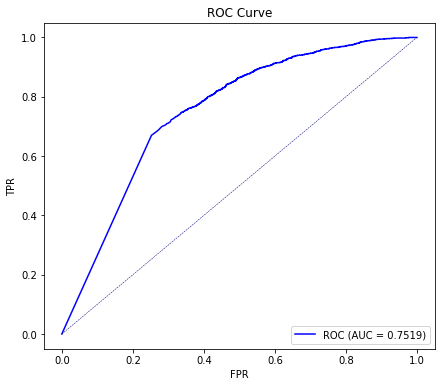

Detector ROC-AUC score: 0.75188


In [95]:
## Evaluate detector
# Compute logistic regression model predictions
probs = lr.predict_proba(values)[:, 1]
# Compute AUC
n_samples = len(X_test)

fpr, tpr, auc_score = compute_roc(
    probs_neg=probs[:n_samples],
    probs_pos=probs[n_samples:],
    labels=labels
)
print('Detector ROC-AUC score: %0.5f' % auc_score)

In [96]:
save_list([fpr, tpr, auc_score], '../roc/artifacts/%s_%s_roc.pkl' % (dataset, attack))

In [97]:
load_list('../roc/artifacts/%s_%s_roc.pkl' % (dataset, attack))[2]

0.751882375

# ROC curve

In [560]:
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_list = []
target_list = []
output_list = []

model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    target = target.reshape(-1, 1)
    output = model(data)
    pred = (output >= 0.5).float()
    
    output_list.append(output.detach().cpu().numpy())
    pred_list.append(pred.detach().cpu().numpy())
    target_list.append(target.detach().cpu().numpy())

pred_list = np.array(pred_list).reshape(-1)
output_list = np.array(output_list).reshape(-1)
target_list = np.array(target_list).reshape(-1)
    
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(target_list, output_list)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(target_list.ravel(), output_list.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

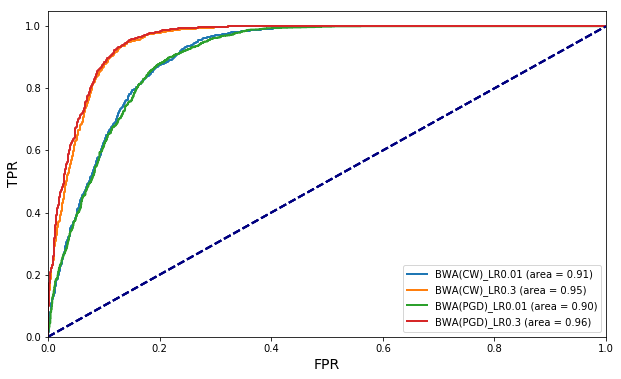

In [590]:
roc_list = ['./roc/roc_BWA(CW)_eps001.pkl', './roc/roc_BWA(CW)_eps03.pkl', 
            './roc/roc_BWA(PGD)_eps001.pkl', './roc/roc_BWA(PGD)_eps03.pkl']
legend_label = ['BWA(CW)_LR0.01', 'BWA(CW)_LR0.3', 'BWA(PGD)_LR0.01', 'BWA(PGD)_LR0.3']
plt.rcParams["figure.figsize"] = (10,6)

for idx, r in enumerate(roc_list):
    # plt.figure()
    lw = 2
    data = load_list(r)
    fpr = data[0]
    tpr = data[1]
    roc_auc = data[2]
    plt.plot(fpr[0], tpr[0],
             lw=lw, label='%s (area = %0.2f)' % (legend_label[idx], roc_auc[0]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR' , fontsize=14)
    plt.ylabel('TPR' , fontsize=14)
    plt.legend(loc="lower right")
plt.show()